In [2]:
from VGBoost import VGBRegressor, VGBClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [4]:
from xgboost import XGBRegressor, XGBClassifier
import pandas as pd

# Regression Benchmarks

In [97]:
df_ = pd.read_csv(r'../dataset/accelerometer.csv')
df = df_.sample(100000).reset_index(drop=True)

@article{ScalabriniSampaio2019,
doi = {10.3390/s19194342},
url = {[Web Link]},
author = {Gustavo Scalabrini Sampaio and Arnaldo Rabello de Aguiar Vallim Filho and Leilton Santos da Silva and Leandro Augusto da Silva},
title = {Prediction of Motor Failure Time Using An Artificial Neural Network},
journal = {Sensors}
year = {2019},
month = oct,
publisher = {{MDPI} {AG}},
volume = {19},
number = {19},
pages = {4342},
}

In [98]:
y = df['pctid']
X = StandardScaler().fit_transform(df.drop('pctid', axis=1))
X_train, X_val, y_train, y_val = train_test_split(
    X[:10000], y[:10000], train_size=.7,)

In [99]:
%%time
reg = ElasticNet()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 0 ns
Wall time: 6.99 ms


{'mse_val': 607.0144486374021,
 'mse_train': 605.9989892957499,
 'r2_val': -8.513477190108532e-05,
 'r2_train': 5.116687876538517e-05}

In [100]:
%%time
reg = Lasso()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 31.2 ms
Wall time: 7.99 ms


{'mse_val': 607.0002448979591,
 'mse_train': 606.0299979591837,
 'r2_val': -6.173343655069274e-05,
 'r2_train': 0.0}

In [101]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 1.53 s
Wall time: 261 ms


{'mse_val': 118.30768874943043,
 'mse_train': 54.78913399438466,
 'r2_val': 0.805082463666029,
 'r2_train': 0.9095933630696698}

In [102]:
%%time
reg = VGBRegressor()
reg.fit(X_train, y_train, light=False, n_random_models=10)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}

CPU times: total: 1min 1s
Wall time: 16.9 s


{'mse_val': 112.06149892999383,
 'mse_train': 83.05902320763165,
 'r2_val': 0.8153733580613839,
 'r2_train': 0.8629456900032435}

In [103]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 2min 39s
Wall time: 1min 1s


{'mse_val': 114.29188226564861,
 'mse_train': 83.21552376524649,
 'r2_val': 0.8116986955820337,
 'r2_train': 0.8626874510412419}

In [61]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:10000], y[:10000], train_size=.7,)

In [62]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 1.47 s
Wall time: 273 ms


{'mse_val': 116.23552618541483,
 'mse_train': 55.326614763974625,
 'r2_val': 0.8041124678313587,
 'r2_train': 0.908628169019718}

In [63]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 37.8 s
Wall time: 12.7 s


{'mse_val': 112.02283730892313,
 'mse_train': 84.72363114366165,
 'r2_val': 0.8112119601715396,
 'r2_train': 0.8600790354168729}

In [64]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 3min 5s
Wall time: 57.4 s


{'mse_val': 114.98742779305822,
 'mse_train': 84.90745838617943,
 'r2_val': 0.8062158429525965,
 'r2_train': 0.8597754449694082}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:5000], y[:5000], train_size=.7,)

In [ ]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 1.61 s
Wall time: 307 ms


{'mse_val': 0.19497399050016945,
 'mse_train': 0.010226599973736627,
 'r2_val': 0.828200609526697,
 'r2_train': 0.991254320544323}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 1min 55s
Wall time: 39.2 s


{'mse_val': 0.19574570859872187,
 'mse_train': 0.04209729726708903,
 'r2_val': 0.8275206178077585,
 'r2_train': 0.9639988394193753}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 19.5 s
Wall time: 5.48 s


{'mse_val': 0.19098225078735104,
 'mse_train': 0.082900097093201,
 'r2_val': 0.8317178912309441,
 'r2_train': 0.9291047192729177}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:10000], y[:10000], train_size=.7,)

In [ ]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 2.72 s
Wall time: 439 ms


{'mse_val': 0.18971173917474976,
 'mse_train': 0.030840499867203792,
 'r2_val': 0.8597163388002005,
 'r2_train': 0.9773612058550046}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 3min 40s
Wall time: 1min 14s


{'mse_val': 0.18241136749321382,
 'mse_train': 0.11526856747542355,
 'r2_val': 0.8651146492688101,
 'r2_train': 0.9153858925211635}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 34.8 s
Wall time: 18.3 s


{'mse_val': 0.1862854589591111,
 'mse_train': 0.11878126080323766,
 'r2_val': 0.8622499254671988,
 'r2_train': 0.9128073629420289}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:15000], y[:15000], train_size=.7,)

In [ ]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 3.89 s
Wall time: 639 ms


{'mse_val': 0.18834848593680398,
 'mse_train': 0.04930039228897205,
 'r2_val': 0.8419366962411791,
 'r2_train': 0.961380802464479}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 6min 38s
Wall time: 2min 10s


{'mse_val': 0.18381579654183638,
 'mse_train': 0.13497625216201362,
 'r2_val': 0.8457405593681784,
 'r2_train': 0.8942670777486872}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 52.6 s
Wall time: 26.7 s


{'mse_val': 0.18306020734505063,
 'mse_train': 0.13699375433853303,
 'r2_val': 0.8463746548541835,
 'r2_train': 0.8926866782535542}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:20000], y[:20000], train_size=.7,)

In [ ]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 5.05 s
Wall time: 855 ms


{'mse_val': 0.24207434057412902,
 'mse_train': 0.06853575465269869,
 'r2_val': 0.8192389270506666,
 'r2_train': 0.9487313012243933}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 9min 45s
Wall time: 2min 59s


{'mse_val': 0.23771505080286465,
 'mse_train': 0.15686953430891148,
 'r2_val': 0.8224940836875986,
 'r2_train': 0.8826525374629898}

In [ ]:
%%time
reg = VGBRegressor()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'mse_val': mean_squared_error(y_val, reg.predict(X_val)),
    'mse_train': mean_squared_error(y_train, reg.predict(X_train)),
    'r2_val': r2_score(y_val, reg.predict(X_val)),
    'r2_train': r2_score(y_train, reg.predict(X_train)),
}


CPU times: total: 45.3 s
Wall time: 21.7 s


{'mse_val': 0.2353329874051367,
 'mse_train': 0.1535519752392486,
 'r2_val': 0.8242728113899458,
 'r2_train': 0.88513426305972}

# Classification Datasets

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=1000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 797 ms
Wall time: 215 ms


{'f1_val': 0.6873065015479876,
 'f1_train': 1.0,
 'roc_auc_score_val': 0.6620648259303722,
 'roc_auc_score_train': 1.0}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=10)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 1min 59s
Wall time: 35.8 s


{'f1_val': 0.7478260869565218,
 'f1_train': 0.9413265306122449,
 'roc_auc_score_val': 0.7057842046718577,
 'roc_auc_score_train': 0.9316017316017315}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 3min 35s
Wall time: 1min 30s


{'f1_val': 0.7365439093484418,
 'f1_train': 0.9238578680203046,
 'roc_auc_score_val': 0.6818546768366118,
 'roc_auc_score_train': 0.9102921695916536}

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=10000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 3.52 s
Wall time: 759 ms


{'f1_val': 0.6847073631214602,
 'f1_train': 1.0,
 'roc_auc_score_val': 0.6653838152693989,
 'roc_auc_score_train': 1.0}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 10min 54s
Wall time: 3min 57s


{'f1_val': 0.718856787822305,
 'f1_train': 0.7798675496688741,
 'roc_auc_score_val': 0.6964433655516458,
 'roc_auc_score_train': 0.7606639684410063}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=10)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 4min
Wall time: 1min 10s


{'f1_val': 0.7180768029971901,
 'f1_train': 0.8935831008369868,
 'roc_auc_score_val': 0.6973609193354415,
 'roc_auc_score_train': 0.8843864952097957}

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=20000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 12.3 s
Wall time: 2.17 s


{'f1_val': 0.7068450039339104,
 'f1_train': 0.9497025419145484,
 'roc_auc_score_val': 0.6882296215305839,
 'roc_auc_score_train': 0.946265943135645}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 26min 9s
Wall time: 9min


{'f1_val': 0.7142628973007507,
 'f1_train': 0.7817722900607137,
 'roc_auc_score_val': 0.701283166436789,
 'roc_auc_score_train': 0.7709729726280532}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=10)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 5min 30s
Wall time: 1min 44s


{'f1_val': 0.7095034110740916,
 'f1_train': 0.9301626349596829,
 'roc_auc_score_val': 0.693958436754194,
 'roc_auc_score_train': 0.9268896565016514}

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=30000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 18.2 s
Wall time: 3.03 s


{'f1_val': 0.7204088017520075,
 'f1_train': 0.9165632204291541,
 'roc_auc_score_val': 0.700599802440368,
 'roc_auc_score_train': 0.9090959517672835}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 1h 43min 17s
Wall time: 42min 37s


{'f1_val': 0.7220534311157675,
 'f1_train': 0.8113837794504075,
 'roc_auc_score_val': 0.7039209571510887,
 'roc_auc_score_train': 0.7969676951749712}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 4min 24s
Wall time: 1min 28s


{'f1_val': 0.7291229542593369,
 'f1_train': 0.8110898491388902,
 'roc_auc_score_val': 0.7118840904341879,
 'roc_auc_score_train': 0.7964414179426588}

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=40000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 23 s
Wall time: 3.64 s


{'f1_val': 0.7238419302451474,
 'f1_train': 0.8907512919040679,
 'roc_auc_score_val': 0.7002745562668508,
 'roc_auc_score_train': 0.8807396776457758}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 3h 48min 49s
Wall time: 1h 33min 2s


{'f1_val': 0.7271022194435762,
 'f1_train': 0.9346240462505462,
 'roc_auc_score_val': 0.7075408817826807,
 'roc_auc_score_train': 0.9302080472438309}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 9min 57s
Wall time: 3min 50s


{'f1_val': 0.7316236651336815,
 'f1_train': 0.7983574527270921,
 'roc_auc_score_val': 0.7114768098458282,
 'roc_auc_score_train': 0.7806628226753496}

In [ ]:
df = pd.read_csv(r'../HIGGS.csv/HIGGS.csv', nrows=50000)
y = df['1.000000000000000000e+00'] 
X = df.drop(['1.000000000000000000e+00'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=.7,)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}


CPU times: total: 26.2 s
Wall time: 5.67 s


{'f1_val': 0.7332587899117903,
 'f1_train': 0.873466803830023,
 'roc_auc_score_val': 0.7118812641313195,
 'roc_auc_score_train': 0.861162951748859}

In [ ]:
%%time
clf = VGBClassifier()
_ = clf.fit(X_train, y_train, complexity=True, n_random_models=5)
{
    'f1_val': f1_score(y_val, clf.predict(X_val)),
    'f1_train': f1_score(y_train, clf.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, clf.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, clf.predict(X_train)),
}

CPU times: total: 7h 26min 27s
Wall time: 4h 24min 22s


{'f1_val': 0.7374594459695532,
 'f1_train': 0.7884930926798285,
 'roc_auc_score_val': 0.7179048120672309,
 'roc_auc_score_train': 0.7697266086746667}

In [ ]:
%%time
reg = VGBClassifier()
_ = reg.fit(X_train, y_train, light=False, n_random_models=5)
{
    'f1_val': f1_score(y_val, reg.predict(X_val)),
    'f1_train': f1_score(y_train, reg.predict(X_train)),
    'roc_auc_score_val': roc_auc_score(y_val, reg.predict(X_val)),
    'roc_auc_score_train': roc_auc_score(y_train, reg.predict(X_train)),
}


CPU times: total: 16min 45s
Wall time: 5min 59s


{'f1_val': 0.7389125997402116,
 'f1_train': 0.7897541416059934,
 'roc_auc_score_val': 0.7164972008312849,
 'roc_auc_score_train': 0.7701317919514868}

# Multiclass Classification

In [ ]:
from sklearn.datasets import fetch_covtype
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
X, y = fetch_covtype(return_X_y=True,)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:1000], y[:1000], train_size=.7, stratify=y[:1000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 1.53 s
Wall time: 351 ms


{'f1_val': 0.7997530160539564,
 'f1_train': 1.0,
 'r2_sval': 0.5264720832553037,
 'r2_train': 1.0}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 3min 44s
Wall time: 1min 21s


{'f1_val': 0.8026206592726212,
 'f1_train': 0.9779947625637742,
 'r2_sval': 0.5585756708312153,
 'r2_train': 0.9411834483304007}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:5000], y[:5000], train_size=.7, stratify=y[:5000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 12 s
Wall time: 2.33 s


{'f1_val': 0.8476413325206937,
 'f1_train': 1.0,
 'r2_sval': 0.6872524813057344,
 'r2_train': 1.0}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 15min 54s
Wall time: 4min 51s


{'f1_val': 0.8493663558199332,
 'f1_train': 0.9844662770294886,
 'r2_sval': 0.6912620648787378,
 'r2_train': 0.9671073028882091}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:10000], y[:10000], train_size=.7, stratify=y[:10000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 22.2 s
Wall time: 5.19 s


{'f1_val': 0.8403497554267313,
 'f1_train': 0.9995555356733127,
 'r2_sval': 0.6833010916729945,
 'r2_train': 0.9995929391736567}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 23min 33s
Wall time: 8min 40s


{'f1_val': 0.845431907834147,
 'f1_train': 0.9881262967571253,
 'r2_sval': 0.6621475386358853,
 'r2_train': 0.9709506592109547}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:15000], y[:15000], train_size=.7, stratify=y[:15000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 32.3 s
Wall time: 5.17 s


{'f1_val': 0.8417065349417145,
 'f1_train': 0.9914110773242235,
 'r2_sval': 0.6614099158919876,
 'r2_train': 0.9893505999701885}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 37min 49s
Wall time: 11min 14s


{'f1_val': 0.8605524102116414,
 'f1_train': 0.9894984848753218,
 'r2_sval': 0.6993691899070384,
 'r2_train': 0.9821165977227664}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:25000], y[:25000], train_size=.7, stratify=y[:25000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 53.3 s
Wall time: 7.76 s


{'f1_val': 0.8905810938007166,
 'f1_train': 0.9921377536602015,
 'r2_sval': 0.792567238063691,
 'r2_train': 0.9891312217938868}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 1h 15min 47s
Wall time: 22min 54s


{'f1_val': 0.9052762552146024,
 'f1_train': 0.992420695372901,
 'r2_sval': 0.8126627469382872,
 'r2_train': 0.9835469729042436}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:35000], y[:35000], train_size=.7, stratify=y[:35000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 1min 37s
Wall time: 15.4 s


{'f1_val': 0.8930292811495282,
 'f1_train': 0.9894037618730138,
 'r2_sval': 0.8179819491884788,
 'r2_train': 0.9873976403126375}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 3h 24min 10s
Wall time: 1h 5min 22s


{'f1_val': 0.9076828608852584,
 'f1_train': 0.9903142538731525,
 'r2_sval': 0.8369874703381492,
 'r2_train': 0.9841828904674155}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:45000], y[:45000], train_size=.7, stratify=y[:45000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 2min 3s
Wall time: 19.1 s


{'f1_val': 0.9001055828595723,
 'f1_train': 0.9888144824161988,
 'r2_sval': 0.8305986713515676,
 'r2_train': 0.983952023888}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

CPU times: total: 3h 17min 18s
Wall time: 1h 7min 34s


{'f1_val': 0.9149398521354789,
 'f1_train': 0.9935465416081968,
 'r2_sval': 0.8518309133519777,
 'r2_train': 0.9885511389932683}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:55000], y[:55000], train_size=.7, stratify=y[:55000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


CPU times: total: 2min
Wall time: 21.7 s


{'f1_val': 0.912133340210217,
 'f1_train': 0.9892597730499972,
 'r2_sval': 0.8560846895658994,
 'r2_train': 0.985479729883104}

In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:65000], y[:65000], train_size=.7, stratify=y[:65000])
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}


In [ ]:
%%time
clf = OneVsRestClassifier(VGBClassifier())
clf.fit(X_train, y_train,)
{
    'f1_val': f1_score(y_val, clf.predict(X_val), average='macro'),
    'f1_train': f1_score(y_train, clf.predict(X_train), average='macro'),
    'r2_sval': r2_score(y_val, clf.predict(X_val)),
    'r2_train': r2_score(y_train, clf.predict(X_train))
}

# Timeseries

https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [6]:
pjme = pd.read_csv(r'../dataset/PJME_hourly.csv', index_col=[0], parse_dates=[0])

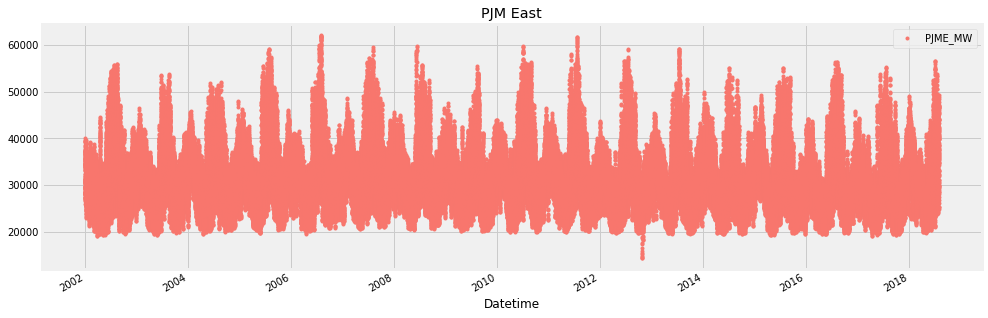

In [7]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [8]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

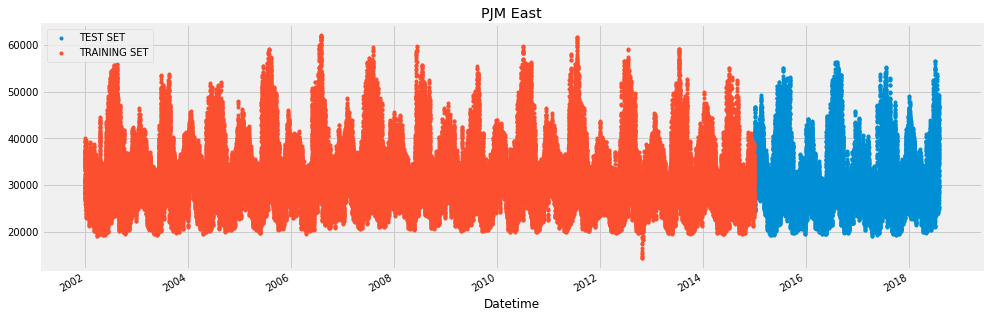

In [9]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [12]:
%%time
reg = XGBRegressor()
reg.fit(X_train, y_train)

pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_train['MW_Prediction'] = reg.predict(X_train)
{
    'mse_val': mean_squared_error(pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction']),
    'mse_train': mean_squared_error(pjme_train['PJME_MW'], y_pred=pjme_train['MW_Prediction']),
    'r2_val': r2_score(pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction']),
    'r2_train': r2_score(pjme_train['PJME_MW'], y_pred=pjme_train['MW_Prediction']),
}

CPU times: total: 14.5 s
Wall time: 2.41 s


{'mse_val': 18118579.746304426,
 'mse_train': 2861154.626244623,
 'r2_val': 0.56445630942802,
 'r2_train': 0.9312744725596329}

In [13]:
%%time
reg = VGBRegressor()
reg.fit(X_train, y_train)

pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_train['MW_Prediction'] = reg.predict(X_train)
{
    'mse_val': mean_squared_error(pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction']),
    'mse_train': mean_squared_error(pjme_train['PJME_MW'], y_pred=pjme_train['MW_Prediction']),
    'r2_val': r2_score(pjme_test['PJME_MW'], y_pred=pjme_test['MW_Prediction']),
    'r2_train': r2_score(pjme_train['PJME_MW'], y_pred=pjme_train['MW_Prediction']),
}